<a href="https://hub.play-sydney.neurodesk.org/user/neurodesk-example-notebooks-toudo5lh/lab/workspaces/auto-4/tree/functional%20imaging/nipype_fsl_second_level_flanker.ipynb" target="_parent"><img src="https://img.shields.io/badge/launch-binder-579aca.svg?logo=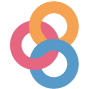" alt="Open In Binder"/>  </a>
<a href="https://colab.research.google.com/github/NeuroDesk/example-notebooks/blob/main/functional%20imaging/nipype_fsl_second_level_flanker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>   </a>

Author: Monika Doerig

Original peper: https://www.frontiersin.org/articles/10.3389/fnimg.2022.953215/full

Original code: https://osf.io/prg53/?view_only=9d7974834a484cdb972bcc3989589b78

## Setup Neurodesk

In [ ]:
%%capture
import os
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  os.environ["LD_PRELOAD"] = "";
  os.environ["APPTAINER_BINDPATH"] = "/content"
  os.environ["MPLCONFIGDIR"] = "/content/matplotlib-mpldir"
  os.environ["LMOD_CMD"] = "/usr/share/lmod/lmod/libexec/lmod"

  !curl -J -O https://raw.githubusercontent.com/NeuroDesk/neurocommand/main/googlecolab_setup.sh
  !chmod +x googlecolab_setup.sh
  !./googlecolab_setup.sh

  os.environ["MODULEPATH"] = ':'.join(map(str, list(map(lambda x: os.path.join(os.path.abspath('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/'), x),os.listdir('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/')))))


# Second level GLM using Nipype FSL

In this notebook, we recreate the second-level GLM of FSL GUI using nipype code. For each nipype node, we list the corresponding fsl command from the log file. The dataset we use is a Flanker task, which can be downloaded [here](https://openneuro.org/datasets/ds000102/versions/00001).

We also borrow some helps from this [document](https://nipype.readthedocs.io/en/latest/users/examples/fmri_fsl.html). 

In [1]:
#load fsl module
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.5.1')
await lmod.list()

['fsl/6.0.5.1']

In [2]:
import os
os.environ["FSLDIR"]="/cvmfs/neurodesk.ardc.edu.au/containers/fsl_6.0.5.1_20221016/fsl_6.0.5.1_20221016.simg/opt/fsl-6.0.5.1/"
os.environ["FSLOUTPUTTYPE"]="NIFTI_GZ"

## Preparation
Import all the relevant libraries needed for the preprocessing stage.

In [3]:
from __future__ import print_function
from __future__ import division
from builtins import str
from builtins import range

import os, stat  # system functions
import getpass
from glob import glob

import numpy as np
from nipype import Function
from nipype.interfaces import fsl, utility as util, io as nio
import nipype.pipeline.engine as pe  # pypeline engine
import nipype.algorithms.modelgen as model  # model generation
import nipype.algorithms.rapidart as ra  # artifact detection

#### Set up data path

In [4]:
# adapted code
# Input: Set path of first level outputs
data_dir = '/neurodesktop-storage/Data/Flanker/output_level1/level1_results/'
# Output: Set path where nipype will store stepwise results
exp_dir = '/neurodesktop-storage/Data/Flanker/output_level2/'

#### Start the workflow

In [5]:
wf = pe.Workflow(name='level2', base_dir=exp_dir)
wf.config["execution"]["crashfile_format"] = "txt"

The following two nodes (`infosource` & `dg`) together define all inputs required for the preprocessing workflow

In [6]:
# we want to group the outcome by contrast not subject
contr_list = [1,2,3,4]
infosource = pe.Node(util.IdentityInterface(fields=["contr_id"]),
                  name="infosource")
infosource.iterables = [("contr_id", contr_list)]

In [7]:
# here we use SelectFiles, instead of DataGrabber, because the former is more flexible with formatting syntax
templates = {
    "reg_copes":"*/reg_copes/*/*/cope{contr_id}_flirt.nii.gz",
    "reg_varcopes":"*/reg_varcopes/*/*/varcope{contr_id}_flirt.nii.gz",
    "reg_masks":"*/reg_masks/*/*/*.nii.gz"
}
dg = pe.Node(interface=nio.SelectFiles(templates),
             name="selectfiles")
dg.inputs.base_directory = data_dir

wf.connect([
        (infosource, dg, [("contr_id", "contr_id")])
])

## Second-level GLM

Combining results from multiple runs of one subject into one

### Higher-level input files preparation

#### Step 1: Merge registered copes & varcopes & masks


**Corresponding FSL command:**
```
/usr/local/fsl/bin/fslmerge -t mask (masks from all 52 inputs)
/usr/local/fsl/bin/fslmerge -t cope (copes from all 52 inputs)
/usr/local/fsl/bin/fslmerge -t varcop (varcopes from all 52 inputs)
```

In [8]:
copemerge = pe.Node(
    interface=fsl.Merge(dimension='t'),
    iterfield=['in_files'],
    name="copemerge")

varcopemerge = pe.Node(
    interface=fsl.Merge(dimension='t'),
    iterfield=['in_files'],
    name="varcopemerge")

maskmerge = pe.Node(
    interface=fsl.Merge(dimension='t'),
    iterfield=['in_files'],
    name="maskmerge")


def sort_copes(files):
    numelements = len(files[0])
    outfiles = []
    for i in range(numelements):
        outfiles.insert(i, [])
        for j, elements in enumerate(files):
            outfiles[i].append(elements[i])
    return outfiles



wf.connect(dg, 'reg_copes', copemerge, 'in_files')
wf.connect(dg, 'reg_varcopes', varcopemerge, 'in_files')
wf.connect(dg, 'reg_masks', maskmerge, 'in_files')

#### Step 2: Making mask

In FSL, there are many commands about `maskunique`, which is unless for the second level. We can ignore it.

**Corresponding FSL command:**
```
/usr/local/fsl/bin/fslmaths mask -Tmin mask
```

In [9]:
minmask = pe.Node(
    interface=fsl.ImageMaths(op_string='-Tmin'),
    iterfield=['in_file'],
    name='minmask')

wf.connect(maskmerge, 'merged_file', minmask, 'in_file')

#### Step 3: Masking copes & varcopes

**Corresponding FSL command:**

we have four contrasts so the following commands repeat four times

```
/usr/local/fsl/bin/fslmaths cope1 -mas mask cope1
/usr/local/fsl/bin/fslmaths varcope1 -mas mask varcope1
```

In [10]:
maskcope = pe.Node(
    interface=fsl.ImageMaths(op_string='-mas'),
    iterfield=['in_file', 'in_file2'],
    name='maskcope')

maskvarcope = pe.Node(
    interface=fsl.ImageMaths(op_string='-mas'),
    iterfield=['in_file', 'in_file2'],
    name='maskvarcope')

wf.connect(copemerge, 'merged_file', maskcope, 'in_file')
wf.connect(minmask, 'out_file', maskcope, 'in_file2')
wf.connect(varcopemerge, 'merged_file', maskvarcope, 'in_file')
wf.connect(minmask, 'out_file', maskvarcope, 'in_file2')

### Set up second-level contrasts and fixed-effects

In [11]:
def get_contrasts_l2(in_files):
    import numpy as np
    total = len(in_files)
    print(in_files)
    print(total)
    n_sub = 26
    ev_list = ['ev'+str(x) for x in range(1,n_sub+1)]
    weight_mtx = np.zeros((26,26))
    weight_mtx = weight_mtx.astype(np.float64)
    np.fill_diagonal(weight_mtx,1.)
    #contr = ['','T',ev_list,list(weight_mtx[0])] --> original paper
    contr = np.array(['','T', ev_list, list(weight_mtx[0])], dtype=object) #adaptation so the construction of the array works
    contr_lst = np.tile(contr, (n_sub, 1))
    contr_lst = [list(x) for x in contr_lst]
    for i in range(n_sub):
        contr_lst[i][3] = list(weight_mtx[i])

    reg_dict = {k:None for k in ev_list}
    for k in reg_dict.keys():
        start_lst = [0.0] * total
        idx = ev_list.index(k)
        start_idx = idx*2
        end_idx = idx*2 + 1
        start_lst[start_idx] = 1.
        start_lst[end_idx] = 1.
        reg_dict[k] = start_lst
        
    return contr_lst, reg_dict

contrastgen_l2 = pe.Node(util.Function(input_names=['in_files'],
                                    output_names=['contr_lst', 'reg_dict'],
                                    function=get_contrasts_l2),
                      iterfield=['in_files'],
                      name='contrastgen_l2')

wf.connect(dg,'reg_copes', contrastgen_l2, 'in_files')

Nipype recommands using [L2Model](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.model.html#l2model), which only works for the single subject. It takes the number of runs (copes at the first level) as input and does estimations for subject one by one.
Instead, we use [MultipleRegressDesign](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.model.html#multipleregressdesign). As it's name indicates, this one can deal with multiple predictors (subjects) at the same time.

In [12]:
level2model = pe.Node(interface=fsl.MultipleRegressDesign(),
                      name='l2model')

wf.connect([(contrastgen_l2, level2model, [('contr_lst','contrasts'),
                                        ('reg_dict','regressors')])])

In [13]:
level2estimate = pe.Node(
    interface=fsl.FLAMEO(run_mode='fe'),
    name="level2estimate",
    iterfield=['cope_file', 'var_cope_file'])

wf.connect([
    (maskcope, level2estimate, [('out_file', 'cope_file')]),
    (maskvarcope, level2estimate, [('out_file', 'var_cope_file')]),
    (minmask, level2estimate, [('out_file', 'mask_file')]),
    (level2model, level2estimate, [('design_mat', 'design_file'),
                                   ('design_con', 't_con_file'), 
                                   ('design_grp', 'cov_split_file')]),
])

In [14]:
datasink = pe.Node(nio.DataSink(), name='sinker')
datasink.inputs.base_directory=os.path.join(exp_dir, "level2_results")

int2string = lambda x: 'contrast_'+str(x)
    
wf.connect(infosource, ('contr_id',int2string), datasink, 'container')
wf.connect([(level2estimate, datasink, [('stats_dir', 'stats_dir')])])

230605-08:50:43,31 nipype.workflow INFO:
	 Generated workflow graph: /neurodesktop-storage/Data/Flanker/output_level2/level2/graph.png (graph2use=colored, simple_form=True).


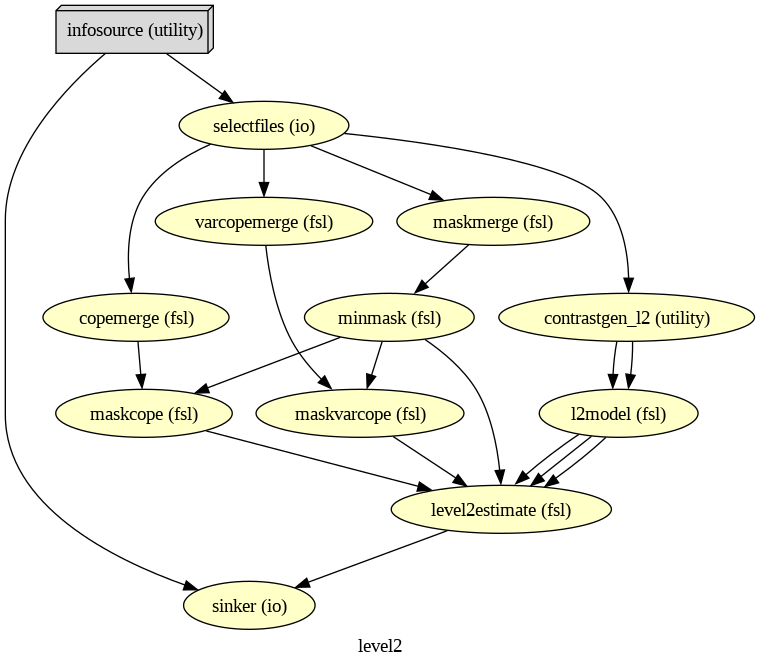

In [15]:
# Create 1st-level analysis output graph
wf.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(wf.base_dir, wf.name, 'graph.png'))

In [16]:
# Run Workflow
wf.run(plugin="MultiProc", plugin_args={"n_procs": 8})

230605-08:50:51,190 nipype.workflow INFO:
	 Workflow level2 settings: ['check', 'execution', 'logging', 'monitoring']
230605-08:50:51,255 nipype.workflow INFO:
	 Running in parallel.
230605-08:50:51,316 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 4 jobs ready. Free memory (GB): 219.50/219.50, Free processors: 8/8.
230605-08:50:51,464 nipype.workflow INFO:
	 [Node] Setting-up "level2.selectfiles" in "/neurodesktop-storage/Data/Flanker/output_level2/level2/_contr_id_1/selectfiles".
230605-08:50:51,467 nipype.workflow INFO:
	 [Node] Setting-up "level2.selectfiles" in "/neurodesktop-storage/Data/Flanker/output_level2/level2/_contr_id_2/selectfiles".
230605-08:50:51,469 nipype.workflow INFO:
	 [Node] Setting-up "level2.selectfiles" in "/neurodesktop-storage/Data/Flanker/output_level2/level2/_contr_id_3/selectfiles".
230605-08:50:51,471 nipype.workflow INFO:
	 [Node] Setting-up "level2.selectfiles" in "/neurodesktop-storage/Data/Flanker/output_level2/level2/_contr_id_4/selectfil

## The second-level GLM

Here we choose the four copes from subject-22

### Regapply

This happens before the second-level GLM, all results from the first level are needed to be registered into the standard space

copes from subject-22, run-2

In [17]:
%%capture
conda install -c conda-forge nilearn
conda install -c conda-forge matplotlib

In [18]:
import numpy as np
import matplotlib.pyplot as plt

import nilearn
from nilearn import surface
from nilearn import plotting

fsaverage = nilearn.datasets.fetch_surf_fsaverage()
plotting.show() 

In [19]:
nipype_cope1 = '/neurodesktop-storage/Data/Flanker/output_level1/level1_results/22/reg_copes/_subject_id_22/_warpfunc1/cope1_flirt.nii.gz'
nipype_cope2 = '/neurodesktop-storage/Data/Flanker/output_level1/level1_results/22/reg_copes/_subject_id_22/_warpfunc1/cope2_flirt.nii.gz'
nipype_cope3 = '/neurodesktop-storage/Data/Flanker/output_level1/level1_results/22/reg_copes/_subject_id_22/_warpfunc1/cope3_flirt.nii.gz'
nipype_cope4 = '/neurodesktop-storage/Data/Flanker/output_level1/level1_results/22/reg_copes/_subject_id_22/_warpfunc1/cope4_flirt.nii.gz'

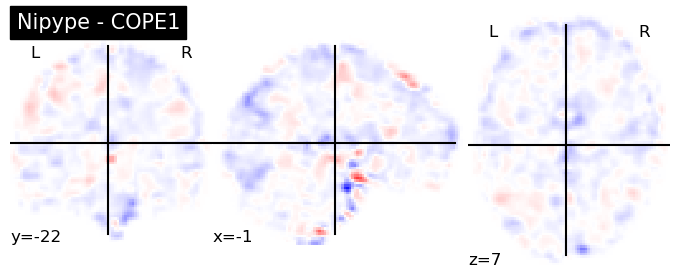

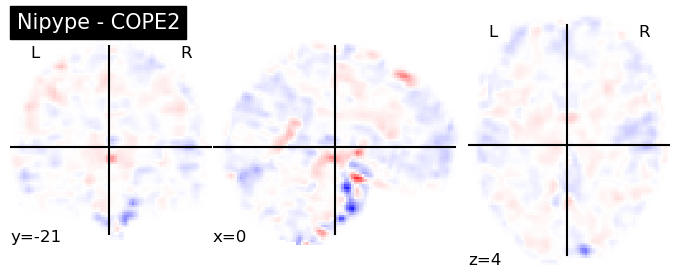

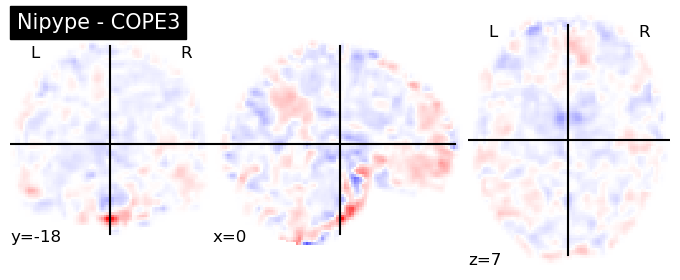

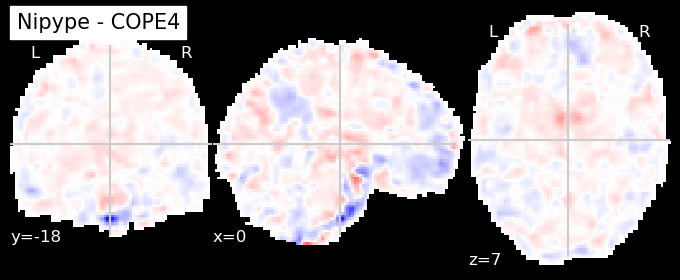

In [20]:
plotting.plot_stat_map(nipype_cope1, bg_img=nipype_cope1, title = 'Nipype - COPE1', cmap = 'bwr', colorbar = False)

plotting.plot_stat_map(nipype_cope2, bg_img=nipype_cope2, title = 'Nipype - COPE2', cmap = 'bwr', colorbar = False)

plotting.plot_stat_map(nipype_cope3, bg_img=nipype_cope3, title = 'Nipype - COPE3', cmap = 'bwr', colorbar = False)

plotting.plot_stat_map(nipype_cope4, bg_img=nipype_cope4, title = 'Nipype - COPE4', cmap = 'bwr', colorbar = False)
plt.show()

### Copes from the second-level GLM

copes from subject-22

In [21]:
nipype_cope1 = '/neurodesktop-storage/Data/Flanker/output_level2/level2_results/contrast_1/stats_dir/_contr_id_1/stats/cope22.nii.gz'
nipype_cope2 = '/neurodesktop-storage/Data/Flanker/output_level2/level2_results/contrast_2/stats_dir/_contr_id_2/stats/cope22.nii.gz'
nipype_cope3 = '/neurodesktop-storage/Data/Flanker/output_level2/level2_results/contrast_3/stats_dir/_contr_id_3/stats/cope22.nii.gz'
nipype_cope4 = '/neurodesktop-storage/Data/Flanker/output_level2/level2_results/contrast_4/stats_dir/_contr_id_4/stats/cope22.nii.gz'

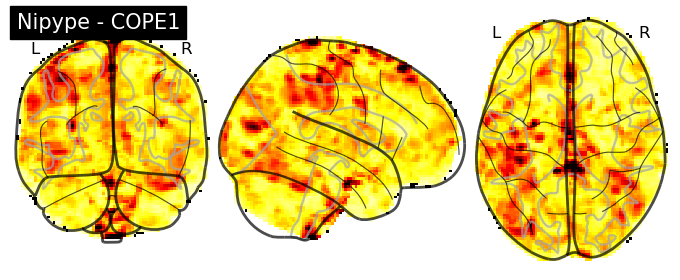

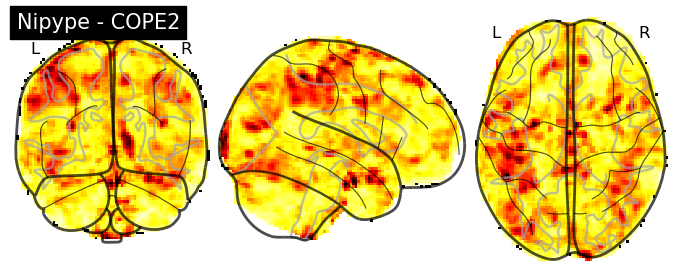

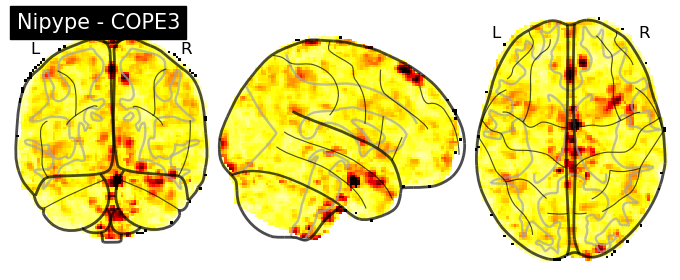

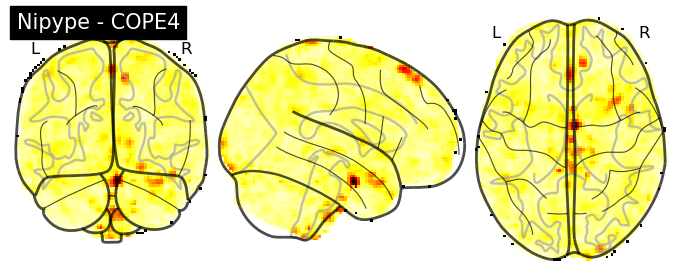

In [22]:
plotting.plot_glass_brain(nipype_cope1, bg_img=nipype_cope1, title = 'Nipype - COPE1')
plotting.plot_glass_brain(nipype_cope2, bg_img=nipype_cope2, title = 'Nipype - COPE2')
plotting.plot_glass_brain(nipype_cope3, bg_img=nipype_cope3, title = 'Nipype - COPE3')
plotting.plot_glass_brain(nipype_cope4, bg_img=nipype_cope4, title = 'Nipype - COPE4')
plt.show()